# Week 10 Assignment - Mixture Models and LDA

As per usual, this assignment is also available on my GitHub at https://github.com/guydav/minerva/blob/master/notebooks/CS156/10.X%20Mixture%20Models%20%2B%20LDA.ipynb

In [4]:
%matplotlib inline

In [18]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
from IPython.display import display

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

# Monthly transaction data

Pre-process the data, spliting the day field, parsing the day of the week, and the amount by shifting it to positive and taking its log. 

In [6]:
# month_to_num snippet from:
# https://stackoverflow.com/questions/3418050/month-name-to-month-number-and-vice-versa-in-python

import calendar
month_to_num = dict((v,k) for k,v in enumerate(calendar.month_abbr))

transaction_data = pandas.read_csv('data/transactions/anonymized.csv')
transaction_data['day'] = [int(d[:2]) for d in transaction_data.Date]
transaction_data['month_year'] = [d[2:] for d in transaction_data.Date]
transaction_data['month'] = [d[2:5] for d in transaction_data.Date]
transaction_data['month_num'] = [month_to_num[m] for m in transaction_data.month]
transaction_data['year'] = [int(d[5:]) for d in transaction_data.Date]
transaction_data['day_of_week'] = [date(row.year, row.month_num, row.day).weekday() 
                                   for _, row in transaction_data.iterrows()]

AMOUNT_SHIFT = min(transaction_data.Amount) - 1
transaction_data['shifted_amount'] = transaction_data.Amount - AMOUNT_SHIFT
transaction_data['log_shifted_amount'] = np.log(transaction_data.shifted_amount)
transaction_data.log_shifted_amount = transaction_data.log_shifted_amount.replace(0, None).dropna()

transaction_data.head()

,Date,Amount,day,month_year,month,month_num,year,day_of_week,shifted_amount,log_shifted_amount
0,25May2016,54241.35,25,May2016,May,5,2016,2,95297.30,11.464757
1,29May2017,54008.83,29,May2017,May,5,2017,0,95064.78,11.462314
2,30Jun2017,54008.82,30,Jun2017,Jun,6,2017,4,95064.77,11.462314
3,05Jan2017,52704.37,5,Jan2017,Jan,1,2017,3,93760.32,11.448497
4,23Feb2017,52704.36,23,Feb2017,Feb,2,2017,3,93760.31,11.448497


In [7]:
transaction_data.groupby('day_of_week').count()

,Date,Amount,day,month_year,month,month_num,year,shifted_amount,log_shifted_amount
day_of_week,,,,,,,,,
0,571,571,571,571,571,571,571,571,571
1,495,495,495,495,495,495,495,495,495
2,384,384,384,384,384,384,384,384,384
3,370,370,370,370,370,370,370,370,370
4,356,356,356,356,356,356,356,356,356
5,342,342,342,342,342,342,342,342,342


Interestingly enough, no transaction end up being processed on Sunday, fascinating!

The function below fits a kernel density, plots it, and and return the density fit

In [8]:
from sklearn.neighbors.kde import KernelDensity

FIGURE_SIZE = (8, 6)

def fit_and_plot(series, kde_bandwidth, hist_name, 
                 hist_bins, hist_title, axes=None, pre_kernel_transform=lambda x: x):
    density_data = pre_kernel_transform(series.as_matrix().reshape((-1, 1)))
    kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(density_data)
    x_range = np.linspace(min(series), max(series), 100).reshape((-1, 1))
    y_density = np.exp(kde.score_samples(x_range))
    
    if axes:
        series.hist(bins=hist_bins, normed=True, ax=axes)
        should_show = False
    else:
        axes = series.hist(bins=hist_bins, normed=True, figsize=FIGURE_SIZE)
        should_show = True
        
    axes.plot(x_range, y_density, color='blue', label='Fit density')
    plt.legend(loc=1, fontsize=12)
    plt.xlabel(hist_title, size=12)
    plt.ylabel(r'Frequency', size=12)
    plt.title(hist_title)
    
    if should_show:
        plt.show()
    
    return kde

## Fit and plot densities
For four particular densities:
* Number of transactions in a month
* Day of the month a transaction takes place on
* Day of the week a transaction takes place on
* Log shifted amount spent in a transcation

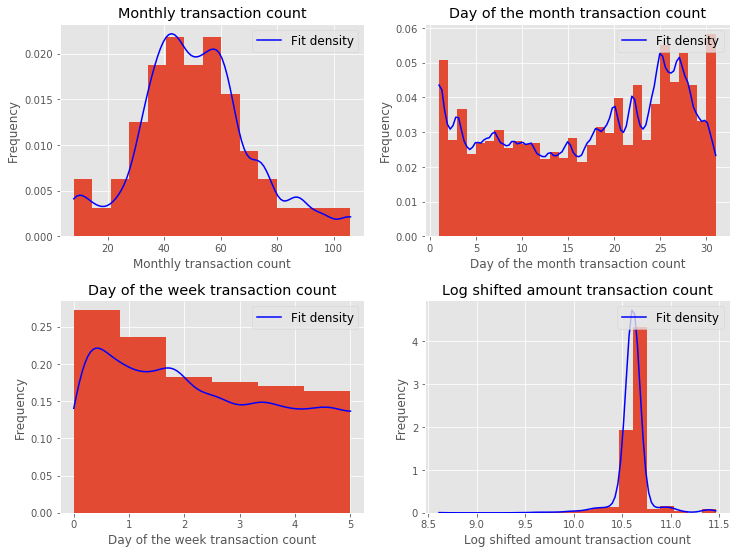

In [9]:
plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(2, 2, hspace=0.3)

counts_by_month = transaction_data.groupby('month_year').count()
month_count_kde = fit_and_plot(counts_by_month.Amount, 4, 'Amount', 15, 
                               'Monthly transaction count', plt.subplot(gs[0, 0]))

day_count_kde = fit_and_plot(transaction_data.day, 0.5, 'day', 30, 
                             'Day of the month transaction count', plt.subplot(gs[0, 1]))

k = 10
day_of_week_count_kde = fit_and_plot(transaction_data.day_of_week, 0.25, 'day_of_week', 6, 
                                     'Day of the week transaction count', plt.subplot(gs[1, 0]),
                                     lambda m: m + (np.random.choice(list(range(k)), m.shape) / k))

log_shifted_amount_kde = fit_and_plot(transaction_data.log_shifted_amount, 0.07, 
                                      'log_shifted_amount', 20, 
                                      'Log shifted amount transaction count', plt.subplot(gs[1, 1]))

plt.show()

## Generate a fake month, and compare distribtions
As quick first order comparisions, we can compare the distribution of prices based on the day of the month, and then the distribution based on the day of the week. 

The fake month is drawn by the following generative model:
1. Draw a number of transactions for the faked month.
2. Draw a day of the month for each transcation.
3. Draw a cost for each transaction, and exp and shift it back to the correct scale. 

Note that each draw is from the independent density fit, with no conditioning on other values drawn.


In [10]:
def generate_fake_month():
    monthly_transactions = month_count_kde.sample().astype(int)[0][0]
    day_of_months = day_count_kde.sample(monthly_transactions * 2).astype(int).reshape((1, -1))[0]
    day_of_months = list(filter(lambda x: x >= 1 and x <= 31, day_of_months))[:monthly_transactions]
    shifted_log_amounts = log_shifted_amount_kde.sample(monthly_transactions).reshape((1, -1))[0]
    amounts = np.exp(shifted_log_amounts) + AMOUNT_SHIFT
    return day_of_months, amounts

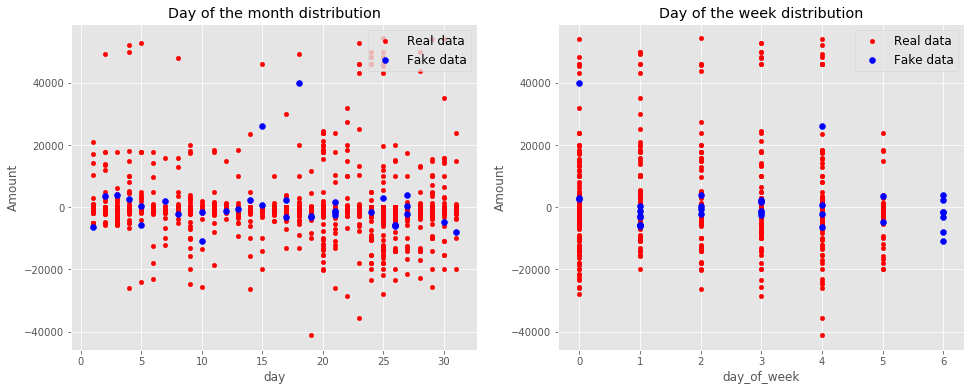

In [11]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, hspace=0.7)

days, amounts = generate_fake_month()
axes = transaction_data.plot('day', 'Amount', kind='scatter', #figsize=FIGURE_SIZE, 
                             color='red', label='Real data', ax=plt.subplot(gs[0, 0]))
axes.scatter(days, amounts, color='blue', label='Fake data')
plt.legend(loc=1, fontsize=12)
plt.title('Day of the month distribution')
# plt.show()

axes = transaction_data.plot('day_of_week', 'Amount', kind='scatter', #figsize=FIGURE_SIZE, 
                             color='red', label='Real data', ax=plt.subplot(gs[0, 1]))
dec_2017_day_of_weeks = [date(2017, 12, day).weekday() for day in days]
axes.scatter(dec_2017_day_of_weeks, amounts, color='blue', label='Fake data')
plt.legend(loc=1, fontsize=12)
plt.title('Day of the week distribution')

plt.show()

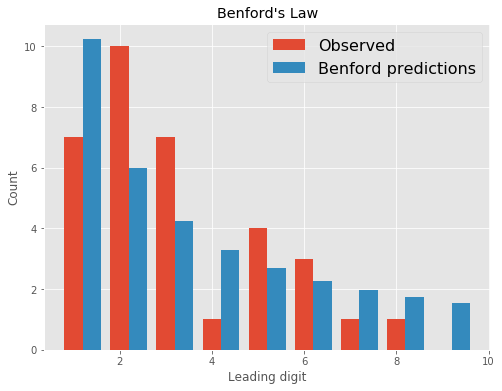

In [12]:
# expected number of each leading digit per Benford's law
# borrowed from https://www.johndcook.com/blog/2011/10/19/benfords-law-and-scipy/
leading_digits = [int(str(abs(x))[0]) for x in amounts]
leading_counts = [leading_digits.count(x) for x in range(1, 10)]
benford = [len(amounts) * np.log10(1 + 1/i) for i in range(1, 10)]

plt.figure(figsize=FIGURE_SIZE)
plt.bar(range(1, 10), leading_counts, width=0.4, label='Observed')
plt.bar([x + 0.4 for x in range(1, 10)], benford, width=0.4, label='Benford predictions')

plt.legend(loc=1, fontsize=16)
plt.title('Benford\'s Law')
plt.xlabel('Leading digit')
plt.ylabel('Count')
plt.show()

## Fake transcations conclusions
* The distribution of days of the months look moderately reasonable, although possibly somewhat under-variable in the amounts. I'm sure we could test this statistically if we so chose.
* Since we draw days of the month independently of day of the week, we end up generating transcations on Sunday, which is obviously an anomaly, given as the database contains no transactions on Sundays.
* Benford's law appears to be somewhat violated as well, with way too many transactions starting with 2, and none with 9, but that doesn't appear to be particularly extreme. 
* I imagine the conditional distributions are probably completley messed up as well. Since we draw all values indepndently, I imagine the distribution of transaction amounts conditioned on day of the week or day of the month look very different than the conditional distributions in the real data. To fix that, we'd might want to draw up a graphical model of what a might contribute to a transaction cost, and then sample accordingly. 


# Book topic modeling

The following code snippet chapterizes the the books by the project Gutenberg format (or at least, tries to), using either the built-in table of contents or provided chapter names:

In [13]:
CONTENTS_OPTIONS = ('CONTENTS', 'Contents')
IGNORE_CONTENTS = ('NOTES', ':', 'CONTENTS', 'Contents', 'Contents:')
SKIP_CONTENTS = ('APPENDIX', 'GLOSSARY')
TERMINATION = '*** END OF THIS PROJECT GUTENBERG EBOOK'

def split_book_by_contents(path, contents=None):
    chapters = OrderedDict()
    
    with open(path) as book_file:
        book = book_file.read()
        
        if not contents:
            contents_start = -1
            for c in CONTENTS_OPTIONS:
                idx = book.find(c)
                if -1 != idx:
                    contents_start = idx + len(c)
                    break

            if -1 == contents_start:
                raise ValueError('Failed to find table of contents, aborting...')

            contents_end = book.find('\n' * 4, contents_start)
            contents = book[contents_start : contents_end].split('\n')
            contents = [c.strip() for c in contents]
            contents = [c for c in contents if c and c not in IGNORE_CONTENTS]
            start_index = contents_end
            
        else:
            start_index = book.find(contents[0]) - 1
        
        contents_and_end = contents + [TERMINATION]
        
        for start_title, end_title in zip(contents, contents[1:]):
            if start_title in SKIP_CONTENTS: continue
                
            chapter_start = book.find(start_title, start_index) + len(start_title)
            chapter_end = book.find(end_title, chapter_start)
            chapters[start_title] = book[chapter_start : chapter_end].strip()
            
            start_index = chapter_end - 1
        
        
    return chapters


The following functions use the above function to read a book in guternberg project format, split it into chapters (and if requested, into equal-length sections of each chapter). The corpus is then vectorized, and then an LDA model with the requested number of topics is fit. The top (default: 10) words of each top components (default: 10) are then printed: 

In [41]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# print_top_words stolen shamelessly from 
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
# and modified to only print the top topics, by their sum:

def print_top_words(model, feature_names, n_top_words=10, n_topics=10):
    topics_and_sums = [(np.sum(topic), topic) for topic in model.components_]
    top_topics = list(sorted(topics_and_sums, reverse=True))[:n_topics]
    
    for topic_idx, (count, topic) in enumerate(top_topics):
        message = "Top topic #%d: " % (topic_idx + 1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]] + ['({c:.3f})'.format(c=count)])
        print(message)
    print()
    
    
def extract_fit_print(book_path, contents=None, n_components=20, min_df=2, split_chapters=None):
    book = split_book_by_contents(book_path, contents)
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=min_df, stop_words='english')
    chapters = [book[c] for c in book]
    
    if split_chapters:
        chapter_words = [chapter.split() for chapter in chapters]
        chapter_lengths = [len(chap) for chap in chapter_words]
        chapter_ranges = [[int(length * i) for i in range(split_chapters + 1)] for length in chapter_lengths]
        chapter_splits = [[' '.join(split[start : end]) for start, end in zip(cr, cr[1:])] 
                          for split, cr in zip(chapter_words, chapter_ranges)]
        chapters = [s for split_chapter in chapter_splits for s in split_chapter]
            
    count_vectors = tf_vectorizer.fit_transform(chapters)

    lda = LatentDirichletAllocation(n_components=n_components, max_iter=20)
    lda.fit(count_vectors)
    
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names)
    
    return lda

In [42]:
comc_lda = extract_fit_print(r'data/books/count_of_monte_cristo.txt', split_chapters=10, n_components=50)

Top topic #1: dantès said caderousse man abbé edmond did replied know poor (34363.491)
Top topic #2: villefort sire police minister king louis noirtier father rue general (892.744)
Top topic #3: villefort renée king marquise letter marquis napoleon saint méran madame (704.000)
Top topic #4: sire majesty king duke louis xviii villefort blacas dear minister (472.110)
Top topic #5: said dantès danglars fernand villefort man caderousse father know replied (94.054)
Top topic #6: dantès danglars morrel owner said captain man edmond young leclere (93.808)
Top topic #7: villefort said dantès man letter know young replied father yes (93.478)
Top topic #8: said villefort king sire dantès majesty man fernand minister caderousse (93.213)
Top topic #9: dantès villefort father man said yes dear letter know replied (93.164)
Top topic #10: said fernand dantès caderousse mercédès danglars edmond replied know villefort (93.162)



In [44]:
federalist_contents = ['FEDERALIST No. {idx}'.format(idx=i + 1) for i in range(84)]
federalist_lda = extract_fit_print(r'data/books/federalist.txt', federalist_contents, n_components=50)

Top topic #1: constitution executive federal ought national legislative body public men senate (39439.179)
Top topic #2: union general national authority federal powers war great nations foreign (22704.143)
Top topic #3: clause imports exports exclusive duties tax article section restriction lay (658.728)
Top topic #4: president union militia different federal body great number shall foreign (490.030)
Top topic #5: public union national executive powers federal constitution general foreign authority (484.634)
Top topic #6: shall union constitution general citizens great united public body national (482.160)
Top topic #7: representatives number federal national constitution time public governments men nature (470.453)
Top topic #8: constitution ought executive great legislature number general representatives public powers (469.246)
Top topic #9: national commerce nations trade great constitution shall union federal time (463.125)
Top topic #10: number federal senate president government

## The Federalist Papers

As mentioned in the Broadway best-seller "Hamilton", Alexander Hamilton, James Madison, and John Jay wrote The Federalist papers the promote the federal structure and government. Hamilton et al. discuss the executive structure of the federal government, and explictly promote a national legislative body, a senate, as made famous by ancient Greece and Rome. They also argue that the government of the entire union should hold the power to enact war and deal with foreign nations, rather than each state independently acting as its own country. This requires the federal branch to have power over tax duties, import and export tariffs, and to control its own, union-wide militia, beyond the individual state ones. They further discuss the appointment process for representatives of these different government branches, how the constituion will outline the structure, and the separation of powers between the executive, legislative, and judicial branches.